<a href="https://colab.research.google.com/github/soulsharp/CV-Algos-Mostly-From-Scratch/blob/main/Watershed_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import cv2 as cv
import matplotlib.pyplot as plt
import random
import numpy as np

In [70]:
# Function to visualize images
def visualize_image(img, title=" ", img_is_gray=False):
  plt.figure()
  plt.axis("off")
  plt.title(title)
  if img_is_gray:
    plt.imshow(img, cmap="gray")
  else:
    plt.imshow(img)

In [71]:
def plot_images_in_a_grid(img_list, num_rows:int, num_cols:int, figure_size:tuple = (10, 5)):
    plt.figure(figsize=figure_size)

    # Handles exception when len(img_list)!= num_rows * num_cols
    for i in range(min(len(img_list), num_rows * num_cols)):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.title(img_list[i][1])
        plt.axis('off')
        plt.imshow(img_list[i][0], cmap='cubehelix')

    plt.show()

In [72]:
img_path = "/content/annie-spratt-_VxyFCTEpW8-unsplash.jpg"
original = cv.imread(img_path)
original = cv.cvtColor(original, cv.COLOR_BGR2RGB)
plot_image_1 = original
plot_image_2 = original
plot_image_1.shape

(1943, 3000, 3)

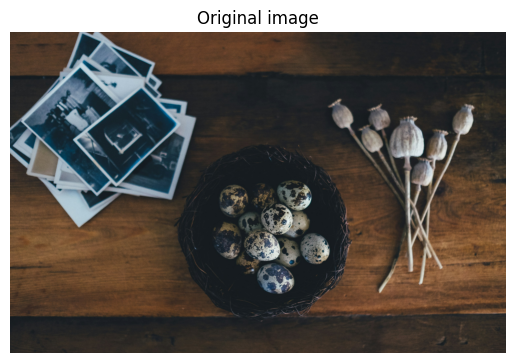

In [73]:
visualize_image(original, "Original image", False)

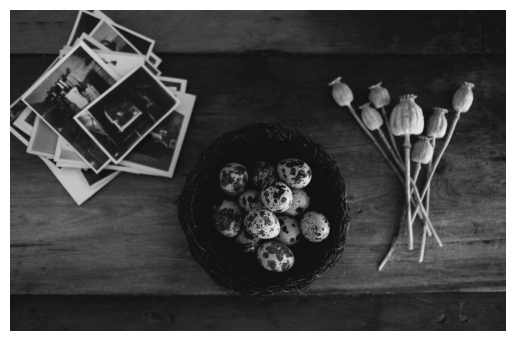

In [74]:
final_img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
visualize_image(final_img, "", True)

In [75]:
# # Skip this block of code if image is too complex as this takes significant time to run
# h, w = final_img.shape
# x = np.arange(0, w, 1)
# y = np.arange(0, h, 1)
# x, y = np.meshgrid(x, y)

# # Plots 3D surface for intensities
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(x, y, final_img, cmap='viridis', rstride=3, cstride=3, edgecolor='none')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Intensity')
# plt.show()

In [76]:
def preprocess_image(gray_img, **kwargs):
  '''
     Takes in :
     - A grayscale image and applies the preprocessing steps needed for the algorithm
     - A dictionary of keyword arguments that define the preprocessing params

     Steps include:
     - Smoothing the image using a bilateral filter
     - Finding the edge map of the smoothed image using a laplacian kernel
     - Converting the image into binary using Otsu's threshold
     - Cleaning up the binary image using morphological operations

     Returns the preprocessed image and the gradient map image
  '''

  # Gets the Bilateral filter parameters from the kwargs dictionary and sets their default values
  bilateral = kwargs.get("Bilateral_Filter_Params", {})
  diameter = bilateral.get("diameter", 9)
  sigma_color = bilateral.get("sigma_color", 75)
  sigma_space = bilateral.get("sigma_space", 75)

  # Gets the Laplacian Filter parameters from the kwargs dictionary and sets their default values
  laplacian = kwargs.get("Laplcaian_Filter_Params", {})
  kernel_size = laplacian.get("ksize", 3)
  depth = laplacian.get("depth", -1)

  # Gets the morphological operations' paramters from the kwargs dictionary and sets their defaults
  morphological_operations = kwargs.get("Morphological_Operations_Params", {})
  open_flag = morphological_operations.get("OPEN_FLAG", True)
  strel_type = morphological_operations.get("Strel_type", 0)
  strel_size = morphological_operations.get("Strel_size", 5)

  # Applies Bilateral Filter to the gray_img
  bilateral_image = cv.bilateralFilter(gray_img, diameter, sigma_color, sigma_space)

  # Applies Laplacian Filter to the bilateral image
  laplacian_image = cv.Laplacian(bilateral_image, depth, kernel_size)

  # Applies Otsu's Binarization to the bilateral filter image to get a binary image
  _, binary_image = cv.threshold(bilateral_image, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)


  # binary_image = cv.dilate(binary_image, kernel, iterations=3)
  # Applies cv.MORPH_OPEN or cv.MORPH_CLOSE to the binary image
  kernel = cv.getStructuringElement(strel_type, (strel_size, strel_size))
  if open_flag:
    binary_image = cv.morphologyEx(binary_image, cv.MORPH_OPEN, kernel)
  else:
    binary_image = cv.morphologyEx(binary_image, cv.MORPH_CLOSE, kernel)

  return binary_image, laplacian_image


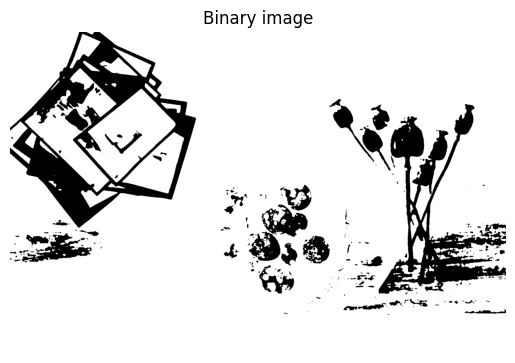

In [77]:
# Arguments given to the preprocess_image function
args_preprocess = {
    "Bilateral_Filter_Params": {
        "diameter": 9,
        "sigma_color": 75,
        "sigma_space": 75
    },
    "Laplacian_Filter_Params": {
        "ksize": 3,
        "depth" : -1
    },
    "Morphological_Operations_Params" : {
        "OPEN_FLAG" :True,
        "Strel_type" : 0,
        "Strel_size" : 3
    }
}

binary_image, gradient_map = preprocess_image(final_img, **args_preprocess)
visualize_image(binary_image, "Binary image", True)

In [78]:
def get_unsure_region(image):
  '''
  Takes in the pre-processed binary image

  Returns the area that's difficult to classify into background and foreground
  '''
  # Gets the region which is definitely part of the background using a rectangular strel of size 3
  kernel = cv.getStructuringElement(0, (3, 3))
  sure_background = cv.dilate(image, kernel, iterations=3)

  # Computes the minimum distance between a pixel and a background pixel for all pixels
  dist_map = cv.distanceTransform(image, cv.DIST_L2, 5)

  # Considers pixels that are at least further than 0.7 * max distance to be the foreground for sure
  # where max_distance is the maximum value on the dist_map
  _, sure_foreground = cv.threshold(dist_map, dist_map.max() * 0.7, 255, cv.THRESH_BINARY)

  # Explicitly specifies data type(needed for cv.subtract)
  sure_foreground = sure_foreground.astype(np.uint8)
  sure_background = sure_background.astype(np.uint8)

  # Gets the region which needs to be classified into background or foreground
  unsure_region = cv.subtract(sure_background, sure_foreground)

  return sure_foreground, sure_background, unsure_region

sure_foreground, sure_background, unsure_region = get_unsure_region(binary_image)

In [79]:
def create_marker_image(sure_foreground, unsure_region):
    '''
    Creates a marker image for the watershed algorithm.

    Parameters:
    - sure_foreground: Binary image of the sure foreground.
    - unsure_region: Binary image of the unsure region.

    Returns:
    - marker_image: The marker image ready for the watershed algorithm.
    '''

    # gets distinct markers for distinct objects using connected components algorithm
    _, markers = cv.connectedComponents(sure_foreground)

    # Adds one to all the markers because the unsure_region is supposed to be passed as 0 to the watershed algo
    markers = markers + 1
    markers[unsure_region == 255] = 0

    return markers

marker_image = create_marker_image(sure_foreground, unsure_region)
print(np.unique(marker_image))

[0 1 2 3 4 5]


In [80]:
# Sanity checks
print(marker_image.shape)
print(gradient_map.shape)

(1943, 3000)
(1943, 3000)


In [81]:
def get_valid_neighbours(height, width, coordinates):
    '''
    Takes in the image height and width and coordinates (tuple) of the pixel in question.
    Returns the coordinates of the neighbors in a numpy array.
    '''
    neighbours = []
    x, y = coordinates
    possible_coordinates = [(0, 1), (0, -1), (1, 0), (-1, 0)]

    for i, j in possible_coordinates:
        nx, ny = x + i, y + j
        # Ensures neighbors are within image bounds
        if 0 <= nx < height and 0 <= ny < width:
            neighbours.append((nx, ny))

    return np.array(neighbours)

In [82]:
import heapq

def build_initial_pq(init_list, gradient_values):
    '''
    Takes in the init_list and the corresponding gradient_values.
    Returns a priority queue, which is a binary heap containing both the grad values and coordinates in a tuple.
    '''
    assert len(init_list) == len(gradient_values)

    # Creates list of tuples with (gradient, coordinates)
    pq = [(gradient_values[i], tuple(init_list[i])) for i in range(len(init_list))]

    # Heapify the list to turn it into a priority queue
    # A binary heap is faster for insertions and deletions
    heapq.heapify(pq)

    return pq


In [83]:
def get_all_initial_unlabelled_neighbours(marker_image, gradient_map, get_valid_neighbours):
    '''Takes in the marker image, the gradient map, and get_valid_neighbours utility function.
       Returns a list containing the initial region to be labelled, along with the modified marker image.
    '''

    height_image, width_image = marker_image.shape[0], marker_image.shape[1]
    initial_list = []
    grad_values = []

    # All gradient values greater than 50 percent of the max gradient value are considered edges and labelled -1
    threshold = 0.5 * np.max(gradient_map)
    indices = (gradient_map >= threshold)
    marker_image[indices] = -1

    # Finds coordinates with values >= 1 in marker_image
    rows, cols = np.where(marker_image >= 1)

    for i in range(len(rows)):
        append_list = []
        neighbours = get_valid_neighbours(height_image, width_image, (rows[i], cols[i]))

        # Only adds "unsure" regions that are marked with 0
        for neighbour in neighbours:
          if(marker_image[neighbour[0], neighbour[1]]==0):
            append_list.append(neighbour)

        initial_list.extend(append_list)

    initial_list = np.array(initial_list)

    for (i, j) in initial_list:
        grad_values.append(gradient_map[i, j])


    return initial_list, np.array(grad_values), marker_image


In [84]:
element_list, gradient_list, marker_modified = get_all_initial_unlabelled_neighbours(marker_image, gradient_map, get_valid_neighbours)
pq = build_initial_pq(element_list, gradient_list)

In [85]:
def watershed_segmentation(pq, gradient_map, marker_image, get_valid_neighbours):
    '''
    Takes in the priority queue, the gradient_map and the marker_image.
    Returns the marker image after applying the watershed transformation.
    '''
    height, width = marker_image.shape[0], marker_image.shape[1]

    # In_queue prevents duplicates to be added into pq
    in_queue = set([current_element[1] for current_element in pq])

    # Prevents duplicates in process_later
    process_later_set = set()
    process_later = []

    while pq:
        current_element = heapq.heappop(pq)
        coordinates = current_element[1]
        neighbours = get_valid_neighbours(height, width, coordinates)
        distinct_neighbours = set(tuple(neighbour) for neighbour in neighbours)
        num_unique_neighbours = len(distinct_neighbours)

        # Case 1: If more than 2 unique neighbours, the point belongs to the watershed
        if num_unique_neighbours > 2:
            marker_image[coordinates] = -1

        # Case 2: When there are exactly 2 unique neighbours
        elif num_unique_neighbours == 2:
            if 0 in distinct_neighbours:
                marker_image[coordinates] = (distinct_neighbours - {0}).pop()
            else:
                marker_image[coordinates] = -1

        # Case 3: When there is exactly one neighbour
        else:
            if 0 in distinct_neighbours:
                # Case 3a: Unclassifiable for now, add to process_later
                if coordinates not in process_later_set:
                    process_later.append(current_element)
                    process_later_set.add(coordinates)
            else:
                # Case 3b: Assign the label of the unique neighbour
                marker_image[coordinates] = distinct_neighbours.pop()

        # Adds unlabelled neighbours to the priority queue if they are not already in there
        for neighbour in neighbours:
          neighbour_tuple = tuple(neighbour)

          if neighbour_tuple not in in_queue and marker_image[neighbour_tuple] == 0:
              gradient_value = gradient_map[neighbour_tuple]
              heapq.heappush(pq, (gradient_value, neighbour_tuple))
              in_queue.add(neighbour_tuple)

    # Post-process the process_later list
    for element in process_later:
        coordinates = element[1]
        neighbours = get_valid_neighbours(height, width, coordinates)
        distinct_neighbours = set(neighbours)

        # Tries to classify the deferred elements
        if len(distinct_neighbours) == 1:
            if 0 not in distinct_neighbours:
                marker_image[coordinates] = distinct_neighbours.pop()
            else:
                marker_image[coordinates] = -1

    return marker_image

In [86]:
marker_image = watershed_segmentation(pq, gradient_map, marker_image, get_valid_neighbours)
np.unique(marker_image, return_counts=True)

(array([-1,  1,  2,  3,  4,  5], dtype=int32),
 array([5023717,  610170,   40999,    1751,     185,  152178]))

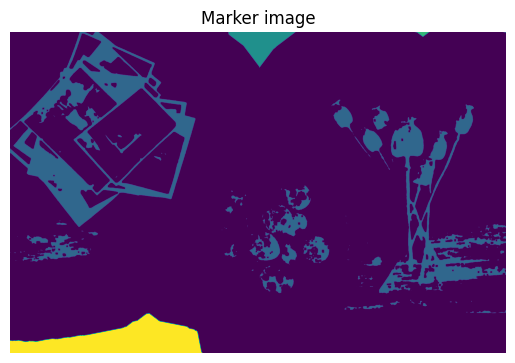

In [87]:
visualize_image(marker_image, "Marker image", False)

In [88]:
plot_image_1.shape

(1943, 3000, 3)

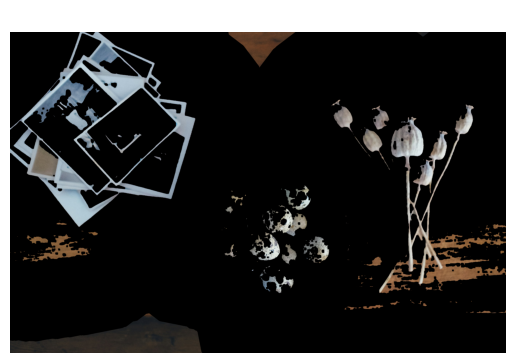

In [89]:
# Overlays the areas marked as -1 by the algorithm on the original image
indices = (marker_image == -1)
plot_image_1[indices] = [0, 0, 0]
visualize_image(plot_image_1)

In [90]:
def get_outermost_contours(marker_image):
  '''Takes in the marker image.
     Returns the outermost contour for each class in the marker image.
  '''

  labels = np.unique(marker_image)
  outlines = []

  # ignores the first 2 labels ie -1, 1
  for label in labels[2:]:
    # Creates a binary image by selecting the region with the label
      binary_mask = np.where(marker_image == label, 255, 0).astype(np.uint8)
    # Performs contour extraction on the created binary image
      contours, heirarchy = cv.findContours(binary_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
      outlines.append(contours[0])

  return outlines


4


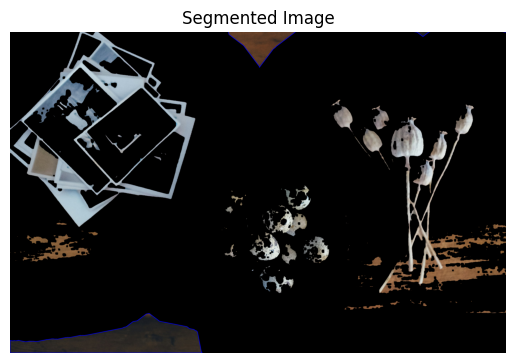

In [91]:
# Overlays contours on the source image
outlines = get_outermost_contours(marker_image)
print(len(outlines))
img = cv.drawContours(plot_image_2, outlines, -1, color=(0 , 0, 255), thickness=2)
visualize_image(img, "Segmented Image", False)